alignSortedKp (531.2528076171875, 1051.6893310546875) referenceSortedKp (304.2661437988281, 425.985595703125)
Number of reference keypoints detected:  30
Number of align image keypoints detected:  31


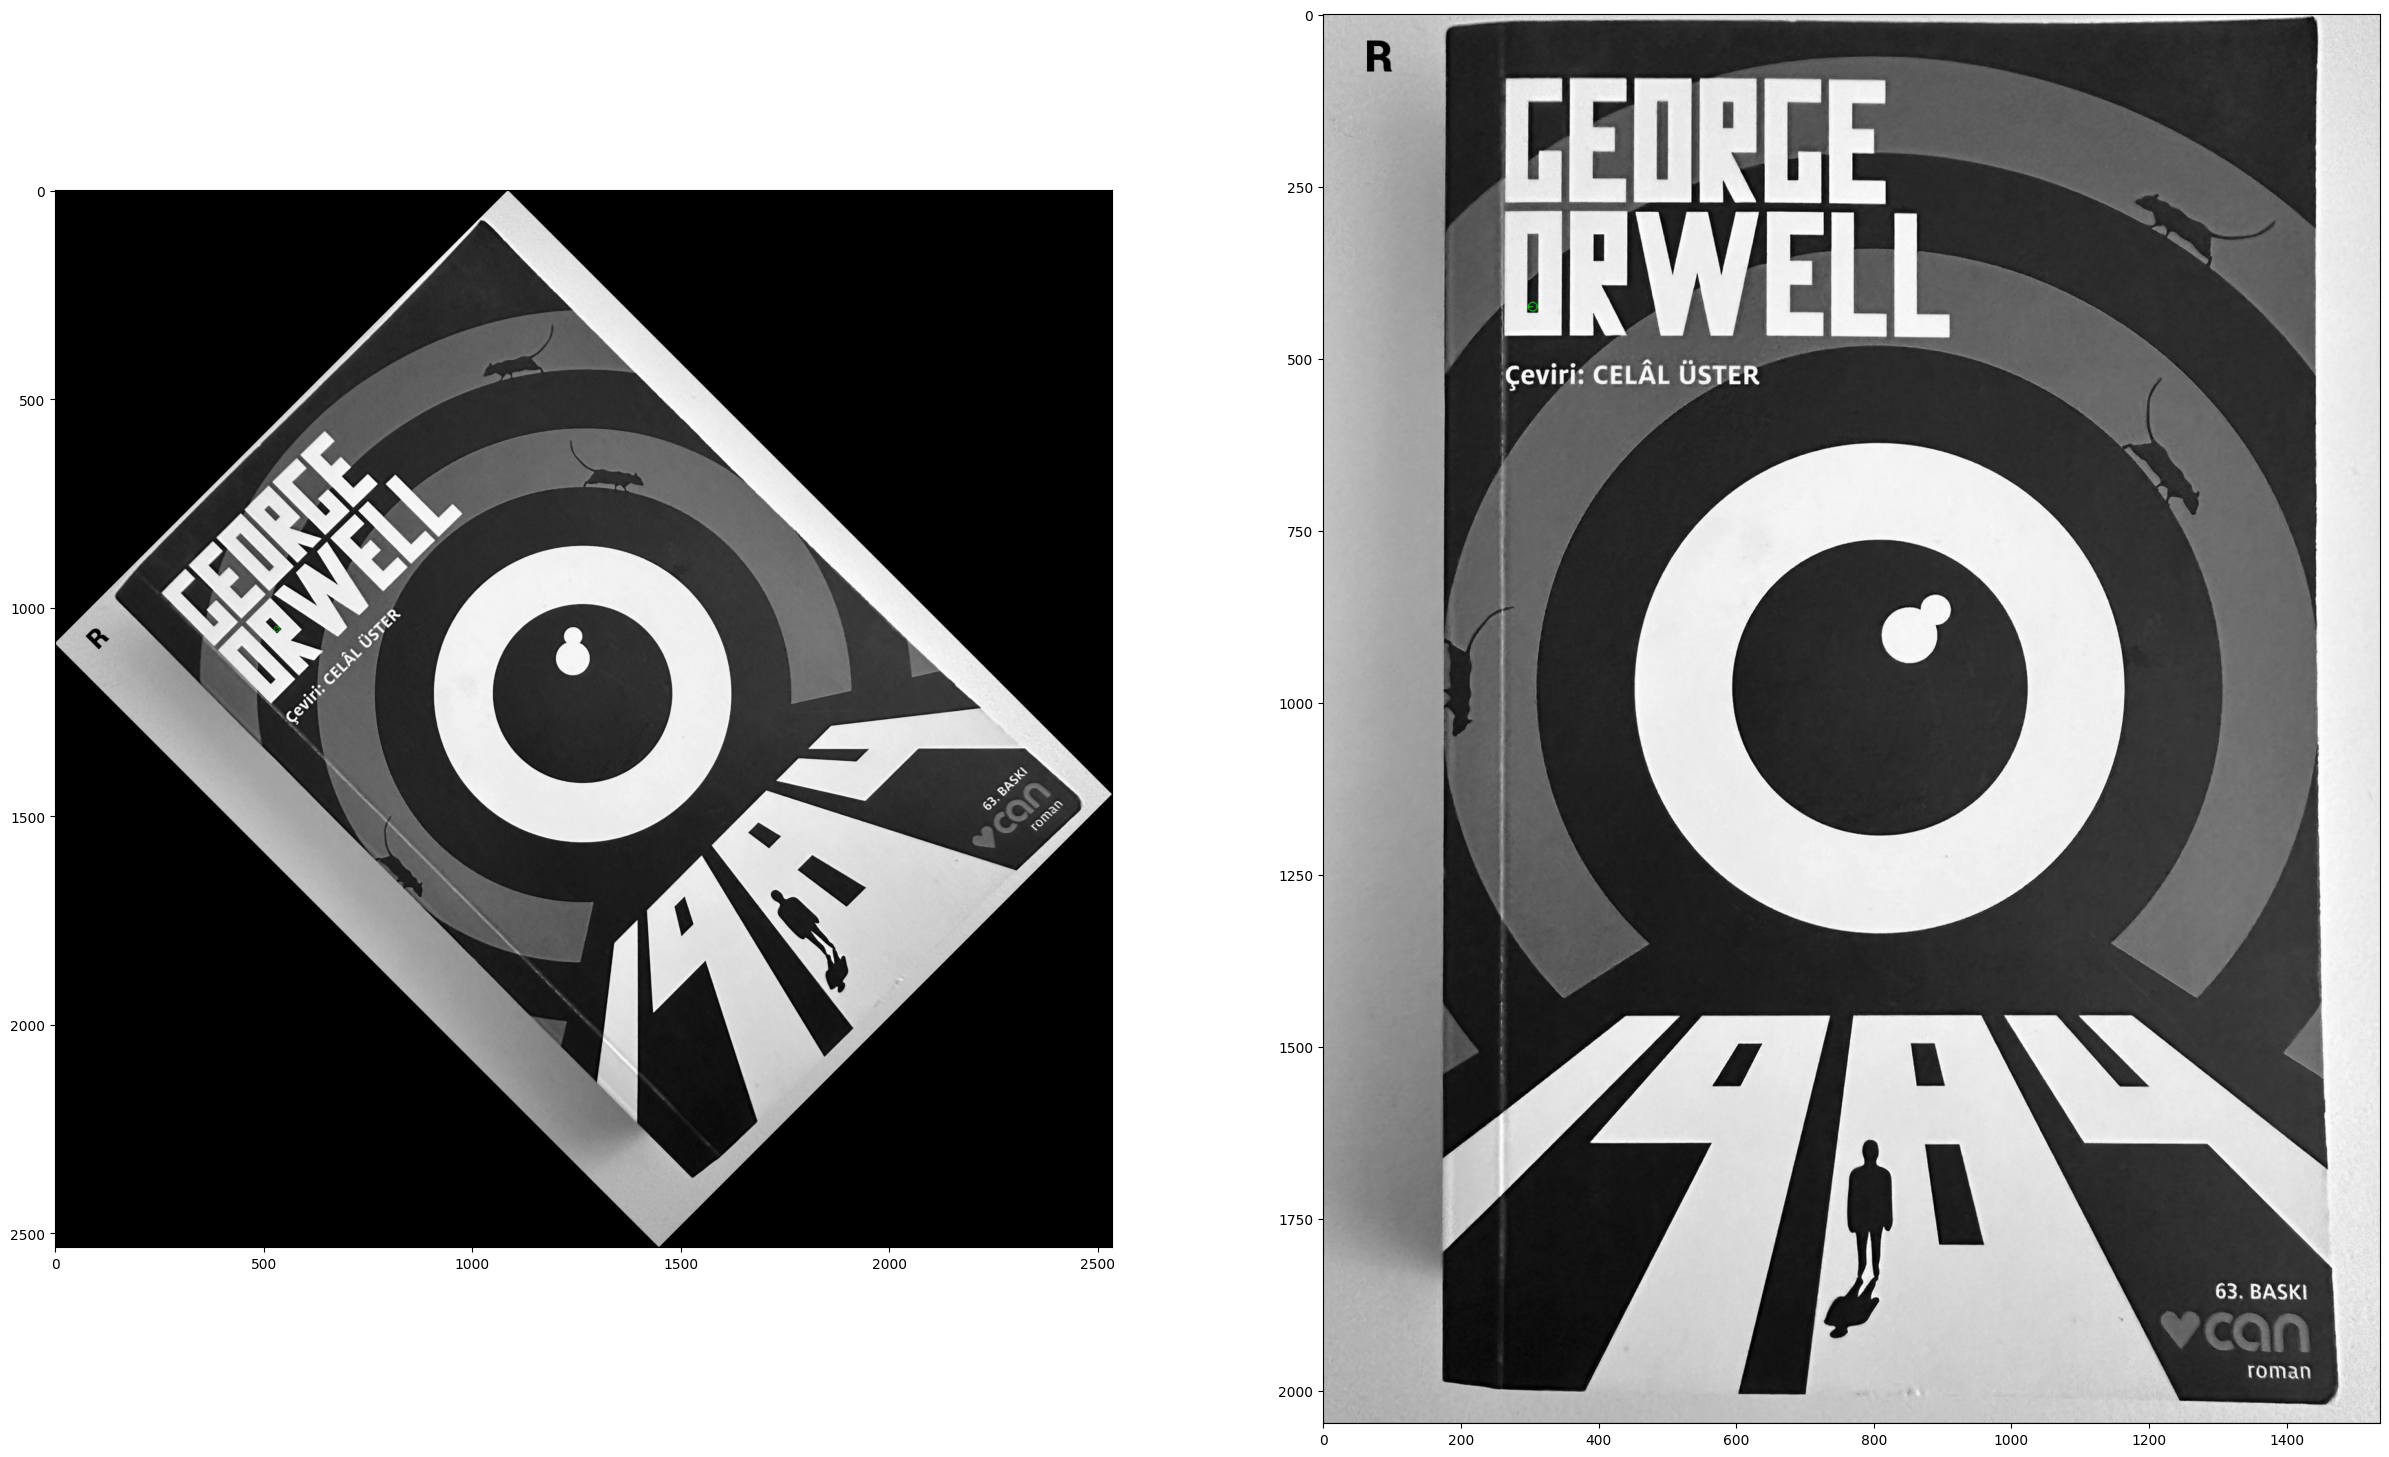

In [41]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imutils

def sort_keypoints_by_coordinates(keypoints):
    return sorted(keypoints, key=lambda kp: kp.pt)

def resize_image_with_fixed_height(img, desired_height):

    height, width = img.shape[:2]
    aspect_ratio = width / height
    new_width = int(desired_height * aspect_ratio)

    return cv2.resize(img, (new_width, desired_height))

desired_height = 800

imgReference = cv2.imread('./images/george1e.jpeg', cv2.IMREAD_GRAYSCALE)
# imgAlign = cv2.imread('./images/george-45degre.jpeg', cv2.IMREAD_GRAYSCALE)

# imgReference = resize_image_with_fixed_height(imgReference, desired_height)

imgAlign = imutils.rotate_bound(imgReference, -45)


sift = cv2.xfeatures2d.SIFT_create(30)
h, w = imgAlign.shape
alignKp, alignDes = sift.detectAndCompute(imgAlign, None)
referenceKp, referenceDes = sift.detectAndCompute(imgReference, None)

alignSortedKp = sort_keypoints_by_coordinates(alignKp)
referenceSortedKp = sort_keypoints_by_coordinates(referenceKp)

DimgAlign = cv2.drawKeypoints(imgAlign, alignSortedKp[9:10], None, color=(0, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
DimgReference = cv2.drawKeypoints(imgReference, referenceSortedKp[7:8], None, color=(0, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

print(f"alignSortedKp {alignSortedKp[9].pt} referenceSortedKp {referenceSortedKp[7].pt}")
print("Number of reference keypoints detected: ", len(referenceKp))
print("Number of align image keypoints detected: ", len(alignKp))

plt.figure(figsize=(30, 30))
plt.subplot(121)
plt.imshow(DimgAlign)
plt.subplot(122)
plt.imshow(DimgReference)
plt.show()


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


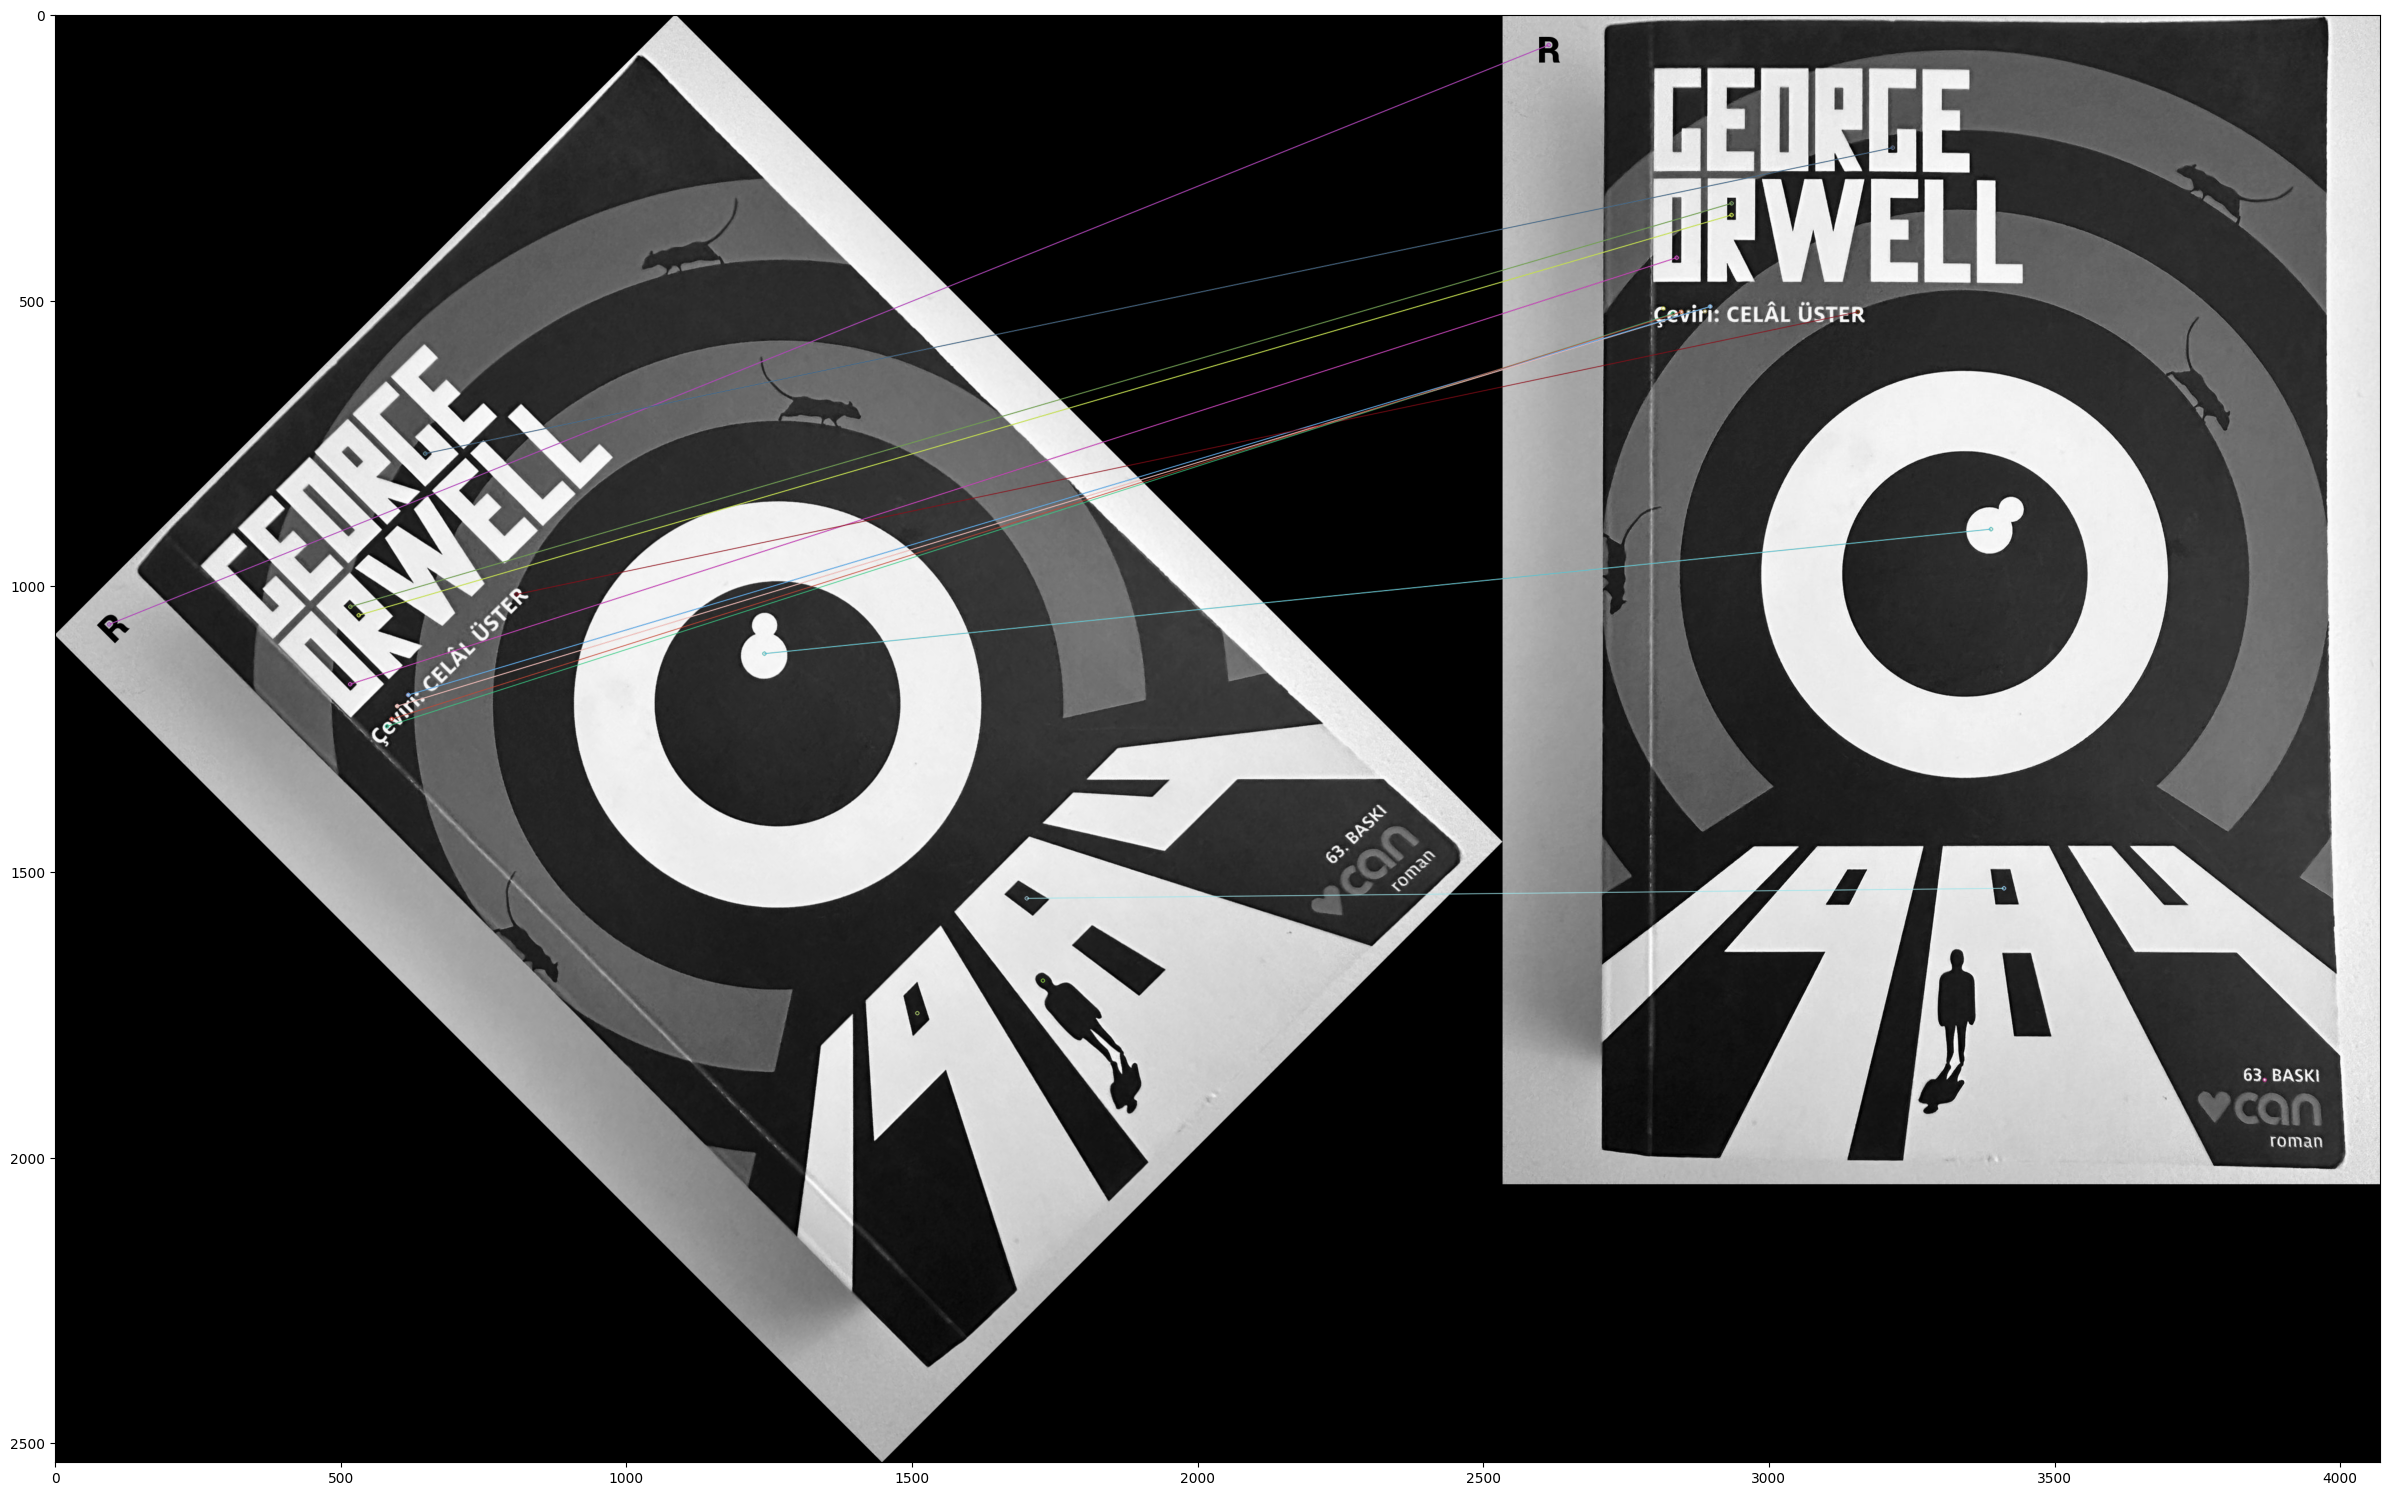

(<matplotlib.image.AxesImage at 0x7f27e42c7610>, None)

In [42]:
print(type(alignDes))
print(type(referenceDes))

matcher = cv2.BFMatcher()
Matches = matcher.knnMatch(alignDes, referenceDes, k=2)

good = []
for m, n in Matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

matchedImage = cv2.drawMatches(imgAlign, alignKp, imgReference, referenceKp, good, None)
plt.figure(figsize=(30, 20))
plt.imshow(matchedImage, 'gray'), plt.show()

Homografi matrisi: 
[[ 7.05520782e-01 -7.06429481e-01  7.67619551e+02]
 [ 7.05622520e-01  7.05205943e-01 -7.65858186e+02]
 [ 1.46938240e-08 -1.87881885e-06  1.00000000e+00]]
Dönüş Açısı: 45.004130790480986 derece


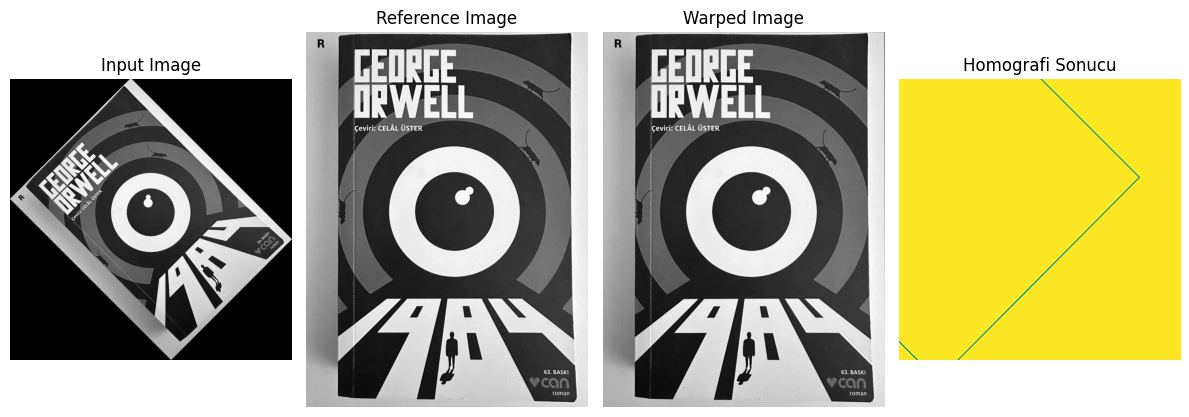

In [43]:
def find_rotation_angle(src_pts, dst_pts):
    # Hesaplanan homografi matrisi oluşturuluyor
    M, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    # Homografi matrisiyle döndürülen açıyı hesaplamak için x ve y eksenlerinin dönüş değerlerini elde edin
    angle_rad = np.arctan2(M[1, 0], M[0, 0])
    angle_deg = np.degrees(angle_rad)
    
    return angle_deg


src_pts = []
dst_pts = []

for match in good:
    src_pts.append(alignKp[match.queryIdx].pt)
    dst_pts.append(referenceKp[match.trainIdx].pt)

src_pts = np.float32(src_pts).reshape(-1, 1, 2)
dst_pts = np.float32(dst_pts).reshape(-1, 1, 2)

M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

if M is None:
    print("Homografi bulunamadı.")

print(f"Homografi matrisi: \n{M}")

offset_x = -400
offset_y = 200

pts = np.float32([
    [0 + offset_x, 0 + offset_y],
    [0 + offset_x, h - 1 + offset_y],
    [w - 1 + offset_x, h - 1 + offset_y],
    [w - 1 + offset_x, 0 + offset_y]
]).reshape(-1, 1, 2)

dst = cv2.perspectiveTransform(pts, M)

im1_reg = cv2.warpPerspective(imgAlign, M, (imgReference.shape[1], imgReference.shape[0]))

empty_frame = np.ones((2500, 2500), dtype=np.uint8) * 255
empty_frame = cv2.polylines(empty_frame, [np.int32(dst)], True, 122, 3, cv2.LINE_AA)

rotation_angle = find_rotation_angle(src_pts, dst_pts)
print(f"Dönüş Açısı: {rotation_angle} derece")

plt.figure(figsize=(12, 6))
plt.subplot(141), plt.imshow(imgAlign, cmap='gray')
plt.title('Input Image'), plt.axis('off')

plt.subplot(142), plt.imshow(imgReference, cmap='gray')
plt.title('Reference Image'), plt.axis('off')

plt.subplot(143), plt.imshow(im1_reg, cmap='gray')
plt.title('Warped Image'), plt.axis('off')

plt.subplot(144), plt.imshow(empty_frame)
plt.title('Homografi Sonucu'), plt.axis('off')


plt.tight_layout()
plt.show()
